# Investor Home Purchases in the San Francisco Housing Market
## Bryan Isaac

In this project, I estimate the effect of investor purchases on housing prices in San Francisco. The data used comes from CoreLogic and contains information on home sales from 2009-2019 in San Francisco. This data was merged with another dataset of home appraisails by the city to add information on number of rooms, bathrooms, square footage, etc. I begin by cleaning and exploring the data, where I find significant differences in mean and median of absentee purchases vs non-absentee purchases. I then perform my regression analysis with a log-linear model and interactions between absentee purchases and neighborhood to determine if effects are location dependent, and find that in the majority of neighborhoods, absentee purchases are made at a lower rate, but in neighborhoods close to downtown, they are made at a higher rate. Finally, I perform a propensity score matching method where I predict propensity to be an absentee purchase using a logistic regression, and use these propensity scores as a control variable in my regression. Results were similar to the non-propensity score method.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
# read in merged data
# data merged in separate file

residences = pd.read_csv('merged_sale_appraisal_all.csv')

C:\Users\bryan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (49,87,134) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
residences.head()

,Unnamed: 0,CLIP,PREVIOUS CLIP,FIPS CODE,APN (PARCEL NUMBER UNFORMATTED),APN SEQUENCE NUMBER,COMPOSITE PROPERTY LINKAGE KEY,ORIGINAL APN,TAX ACCOUNT NUMBER,ONLINE FORMATTED PARCEL ID,LAND USE CODE - STATIC,COUNTY USE DESCRIPTION - STATIC,STATE USE DESCRIPTION - STATIC,MOBILE HOME INDICATOR,ZONING CODE - STATIC,PROPERTY INDICATOR CODE - STATIC,ACTUAL YEAR BUILT - STATIC,EFFECTIVE YEAR BUILT - STATIC,TOTAL NUMBER OF BUILDINGS,DEED SITUS HOUSE NUMBER - STATIC,DEED SITUS HOUSE NUMBER SUFFIX - STATIC,DEED SITUS HOUSE NUMBER 2 - STATIC,DEED SITUS DIRECTION - STATIC,DEED SITUS STREET NAME - STATIC,DEED SITUS MODE - STATIC,DEED SITUS QUADRANT - STATIC,DEED SITUS UNIT NUMBER - STATIC,DEED SITUS CITY - STATIC,DEED SITUS STATE - STATIC,DEED SITUS ZIP CODE - STATIC,DEED SITUS COUNTY - STATIC,DEED SITUS CARRIER ROUTE - STATIC,DEED SITUS STREET ADDRESS - STATIC,STANDARDIZED ADDRESS CONFIDENCE CODE,TRANSACTION FIPS CODE,OWNER TRANSFER COMPOSITE TRANSACTION ID,TRANSACTION BATCH DATE,TRANSACTION BATCH SEQUENCE NUMBER,PENDING RECORD INDICATOR,MULTI OR SPLIT PARCEL CODE,PRIMARY CATEGORY CODE,DEED CATEGORY TYPE CODE,SALE TYPE CODE,SALE AMOUNT,SALE DERIVED DATE,SALE DERIVED RECORDING DATE,SALE DOCUMENT TYPE CODE,SALE RECORDED DOCUMENT NUMBER,SALE RECORDED DOCUMENT BOOK NUMBER,SALE RECORDED DOCUMENT PAGE NUMBER,OWNERSHIP TRANSFER PERCENTAGE,TITLE COMPANY NAME,TITLE COMPANY CODE,CASH PURCHASE INDICATOR,MORTGAGE PURCHASE INDICATOR,INTERFAMILY RELATED INDICATOR,INVESTOR PURCHASE INDICATOR,RESALE INDICATOR,NEW CONSTRUCTION INDICATOR,RESIDENTIAL INDICATOR,SHORT SALE INDICATOR,FORECLOSURE REO INDICATOR,FORECLOSURE REO SALE INDICATOR,BUYER 1 FULL NAME,BUYER 1 LAST NAME,BUYER 1 FIRST NAME AND MIDDLE INITIAL,BUYER 2 FULL NAME,BUYER 2 LAST NAME,BUYER 2 FIRST NAME AND MIDDLE INITIAL,BUYER 1 CORPORATE INDICATOR,BUYER 2 CORPORATE INDICATOR,BUYER 3 FULL NAME,BUYER 3 LAST NAME,BUYER 3 FIRST NAME AND MIDDLE INITIAL,BUYER 3 CORPORATE INDICATOR,BUYER 4 FULL NAME,BUYER 4 LAST NAME,BUYER 4 FIRST NAME AND MIDDLE INITIAL,BUYER 4 CORPORATE INDICATOR,BUYER ETAL CODE,BUYER OWNERSHIP RIGHTS CODE,BUYER RELATIONSHIP TYPE CODE,BUYER CARE OF NAME,BUYER OCCUPANCY CODE,PARTIAL INTEREST INDICATOR,BUYER MAILING HOUSE NUMBER,BUYER MAILING HOUSE NUMBER SUFFIX,BUYER MAILING HOUSE NUMBER 2,BUYER MAILING DIRECTION,BUYER MAILING STREET NAME,BUYER MAILING MODE,BUYER MAILING QUADRANT,BUYER MAILING UNIT NUMBER,BUYER MAILING CITY,BUYER MAILING STATE,BUYER MAILING ZIP CODE,BUYER MAILING CARRIER ROUTE,BUYER MAILING STREET ADDRESS,SELLER 1 FULL NAME,SELLER 1 LAST NAME,SELLER 1 FIRST NAME,SELLER 2 FULL NAME,RECORD ACTION INDICATOR,parcel,sale_year,parcel year,Closed Roll Year,Property Location,Parcel Number,Block,Lot,Volume Number,Use Code,Use Definition,Property Class Code,Property Class Code Definition,Year Property Built,Number of Bathrooms,Number of Bedrooms,Number of Rooms,Number of Stories,Number of Units,Zoning Code,Construction Type,Lot Depth,Lot Frontage,Property Area,Basement Area,Lot Area,Lot Code,Tax Rate Area Code,Percent of Ownership,Exemption Code,Exemption Code Definition,Status Code,Misc Exemption Value,Homeowner Exemption Value,Current Sales Date,Assessed Fixtures Value,Assessed Improvement Value,Assessed Land Value,Assessed Personal Property Value,Assessor Neighborhood District,Assessor Neighborhood Code,Assessor Neighborhood,Supervisor District,Analysis Neighborhood,the_geom,Row ID,SF Find Neighborhoods 2,Current Police Districts 2,Current Supervisor Districts 2,Analysis Neighborhoods 2,DELETE - Supervisor Districts 2,DELETE - Fire Prevention Districts 2,DELETE - Current Police Districts 2,DELETE - Zip Codes 2,DELETE - Neighborhoods 2,DELETE - Police Districts 2,Neighborhoods
0,0,1086805218.00,NaN,6075.00,0776 047,1.00,060750776 047 ...,0776 047,NaN,0776-047,112.00,NaN,NaN,NaN,NaN,11.00,2016.00,NaN,1.00,1474,NaN,NaN,NaN,MCALLISTER,ST,NaN,NaN,SAN FRANCISCO,CA,941154519.00,SAN FRANCISCO,C029,1474 MCALLISTER ST,AS0,6075,60752019082700030,20190827,30,NaN,NaN,A,G,F,2010000.00,2019

In [4]:
residences.shape

(79242, 160)

### Property Codes

In [5]:
residences['PROPERTY INDICATOR CODE - STATIC'].value_counts()

11.00    39745
10.00    33514
21.00     5983
Name: PROPERTY INDICATOR CODE - STATIC, dtype: int64

In [6]:
# transform property codes
def code_to_word(code):
    if code == 10:
        return 'Single Family Residential'
    elif code == 11:
        return 'Condominium'
    else: return 'Duplex'

In [7]:
residences['Property_type'] = residences['PROPERTY INDICATOR CODE - STATIC'].transform(code_to_word)

### Absentees

In [8]:
residences['BUYER OCCUPANCY CODE'].value_counts()

S    52818
T    23763
Name: BUYER OCCUPANCY CODE, dtype: int64

In [9]:
# CoreLogic data lists an absentee purchase as 'BUYER OCCUPANCY CODE' = 'T'
residences['absentee'] = np.where(residences['BUYER OCCUPANCY CODE'] == 'T', 1, 0)

In [10]:
residences[(residences['DEED SITUS STREET ADDRESS - STATIC'] == residences['BUYER MAILING STREET ADDRESS']) & residences['absentee'] == 1]

,Unnamed: 0,CLIP,PREVIOUS CLIP,FIPS CODE,APN (PARCEL NUMBER UNFORMATTED),APN SEQUENCE NUMBER,COMPOSITE PROPERTY LINKAGE KEY,ORIGINAL APN,TAX ACCOUNT NUMBER,ONLINE FORMATTED PARCEL ID,LAND USE CODE - STATIC,COUNTY USE DESCRIPTION - STATIC,STATE USE DESCRIPTION - STATIC,MOBILE HOME INDICATOR,ZONING CODE - STATIC,PROPERTY INDICATOR CODE - STATIC,ACTUAL YEAR BUILT - STATIC,EFFECTIVE YEAR BUILT - STATIC,TOTAL NUMBER OF BUILDINGS,DEED SITUS HOUSE NUMBER - STATIC,DEED SITUS HOUSE NUMBER SUFFIX - STATIC,DEED SITUS HOUSE NUMBER 2 - STATIC,DEED SITUS DIRECTION - STATIC,DEED SITUS STREET NAME - STATIC,DEED SITUS MODE - STATIC,DEED SITUS QUADRANT - STATIC,DEED SITUS UNIT NUMBER - STATIC,DEED SITUS CITY - STATIC,DEED SITUS STATE - STATIC,DEED SITUS ZIP CODE - STATIC,DEED SITUS COUNTY - STATIC,DEED SITUS CARRIER ROUTE - STATIC,DEED SITUS STREET ADDRESS - STATIC,STANDARDIZED ADDRESS CONFIDENCE CODE,TRANSACTION FIPS CODE,OWNER TRANSFER COMPOSITE TRANSACTION ID,TRANSACTION BATCH DATE,TRANSACTION BATCH SEQUENCE NUMBER,PENDING RECORD INDICATOR,MULTI OR SPLIT PARCEL CODE,PRIMARY CATEGORY CODE,DEED CATEGORY TYPE CODE,SALE TYPE CODE,SALE AMOUNT,SALE DERIVED DATE,SALE DERIVED RECORDING DATE,SALE DOCUMENT TYPE CODE,SALE RECORDED DOCUMENT NUMBER,SALE RECORDED DOCUMENT BOOK NUMBER,SALE RECORDED DOCUMENT PAGE NUMBER,OWNERSHIP TRANSFER PERCENTAGE,TITLE COMPANY NAME,TITLE COMPANY CODE,CASH PURCHASE INDICATOR,MORTGAGE PURCHASE INDICATOR,INTERFAMILY RELATED INDICATOR,INVESTOR PURCHASE INDICATOR,RESALE INDICATOR,NEW CONSTRUCTION INDICATOR,RESIDENTIAL INDICATOR,SHORT SALE INDICATOR,FORECLOSURE REO INDICATOR,FORECLOSURE REO SALE INDICATOR,BUYER 1 FULL NAME,BUYER 1 LAST NAME,BUYER 1 FIRST NAME AND MIDDLE INITIAL,BUYER 2 FULL NAME,BUYER 2 LAST NAME,BUYER 2 FIRST NAME AND MIDDLE INITIAL,BUYER 1 CORPORATE INDICATOR,BUYER 2 CORPORATE INDICATOR,BUYER 3 FULL NAME,BUYER 3 LAST NAME,BUYER 3 FIRST NAME AND MIDDLE INITIAL,BUYER 3 CORPORATE INDICATOR,BUYER 4 FULL NAME,BUYER 4 LAST NAME,BUYER 4 FIRST NAME AND MIDDLE INITIAL,BUYER 4 CORPORATE INDICATOR,BUYER ETAL CODE,BUYER OWNERSHIP RIGHTS CODE,BUYER RELATIONSHIP TYPE CODE,BUYER CARE OF NAME,BUYER OCCUPANCY CODE,PARTIAL INTEREST INDICATOR,BUYER MAILING HOUSE NUMBER,BUYER MAILING HOUSE NUMBER SUFFIX,BUYER MAILING HOUSE NUMBER 2,BUYER MAILING DIRECTION,BUYER MAILING STREET NAME,BUYER MAILING MODE,BUYER MAILING QUADRANT,BUYER MAILING UNIT NUMBER,BUYER MAILING CITY,BUYER MAILING STATE,BUYER MAILING ZIP CODE,BUYER MAILING CARRIER ROUTE,BUYER MAILING STREET ADDRESS,SELLER 1 FULL NAME,SELLER 1 LAST NAME,SELLER 1 FIRST NAME,SELLER 2 FULL NAME,RECORD ACTION INDICATOR,parcel,sale_year,parcel year,Closed Roll Year,Property Location,Parcel Number,Block,Lot,Volume Number,Use Code,Use Definition,Property Class Code,Property Class Code Definition,Year Property Built,Number of Bathrooms,Number of Bedrooms,Number of Rooms,Number of Stories,Number of Units,Zoning Code,Construction Type,Lot Depth,Lot Frontage,Property Area,Basement Area,Lot Area,Lot Code,Tax Rate Area Code,Percent of Ownership,Exemption Code,Exemption Code Definition,Status Code,Misc Exemption Value,Homeowner Exemption Value,Current Sales Date,Assessed Fixtures Value,Assessed Improvement Value,Assessed Land Value,Assessed Personal Property Value,Assessor Neighborhood District,Assessor Neighborhood Code,Assessor Neighborhood,Supervisor District,Analysis Neighborhood,the_geom,Row ID,SF Find Neighborhoods 2,Current Police Districts 2,Current Supervisor Districts 2,Analysis Neighborhoods 2,DELETE - Supervisor Districts 2,DELETE - Fire Prevention Districts 2,DELETE - Current Police Districts 2,DELETE - Zip Codes 2,DELETE - Neighborhoods 2,DELETE - Police Districts 2,Neighborhoods,Property_type,absentee
103,103,2677246564.00,NaN,6075.00,0596 008,1.00,060750596 008 ...,0596 008,NaN,0596-008,106.00,NaN,NaN,NaN,RM1,11.00,1908.00,NaN,1.00,1504,NaN,NaN,NaN,JACKSON,ST,NaN,NaN,SAN FRANCISCO,CA,941093148.00,SAN FRANCISCO,C035,1506 JACKSON ST #2,AS0,6075,60752015122100095,20151221,95,NaN,N

### Sale Amount

In [11]:
residences['SALE AMOUNT'].describe()

count       79242.00
mean      1538770.99
std       5703187.99
min           100.00
25%        605000.00
50%        910000.00
75%       1425000.00
max     378500000.00
Name: SALE AMOUNT, dtype: float64

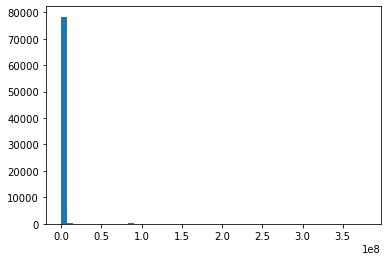

In [12]:
plt.hist(residences['SALE AMOUNT'], bins = 50)
plt.show()

In [13]:
# 624 residences more than $10 million
residences[residences['SALE AMOUNT'] > 10000000].shape

(626, 162)

In [14]:
# remove high outliers
residences = residences[residences['SALE AMOUNT'] < 10000000]

In [15]:
# remove Presidio with very few observations and very high outliers
residences = residences[residences['Analysis Neighborhood'] != 'Presidio']

In [16]:
residences['SALE AMOUNT'].mean()

1158446.1148940767

In [17]:
residences['SALE AMOUNT'].median()

903000.0

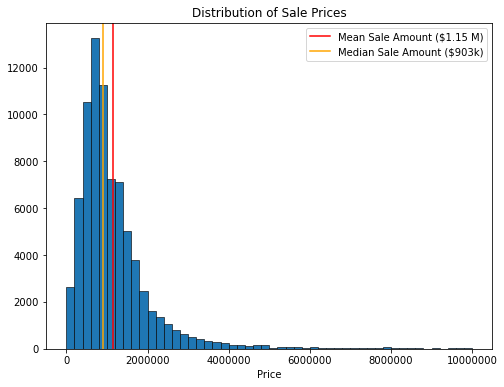

In [18]:
fig, ax = plt.subplots(figsize = (8,6))

plt.hist(residences['SALE AMOUNT'], bins = 50, edgecolor = 'black', linewidth = 0.6)

ax.ticklabel_format(style = 'plain')
ax.set_title('Distribution of Sale Prices')
ax.set_xlabel('Price')

ax.axvline(x = residences['SALE AMOUNT'].mean(), color = 'red', label = 'Mean Sale Amount ($1.15 M)')
ax.axvline(x = residences['SALE AMOUNT'].median(), color = 'orange', label = 'Median Sale Amount ($903k)')

ax.legend()
plt.show()

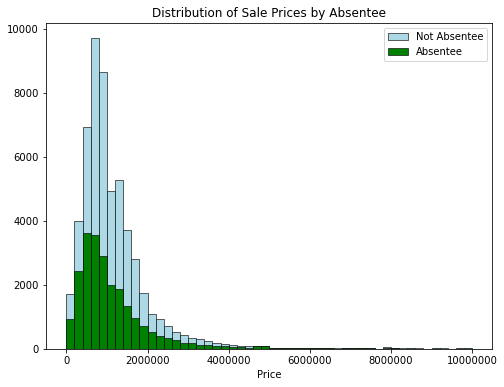

In [19]:
fig, ax = plt.subplots(figsize = (8,6))

plt.hist(residences[residences['absentee'] == 0]['SALE AMOUNT'], bins = 50, edgecolor = 'black', linewidth = 0.6, color = 'lightblue', label = 'Not Absentee')
plt.hist(residences[residences['absentee'] == 1]['SALE AMOUNT'], bins = 50, edgecolor = 'black', linewidth = 0.6, color = 'green', label = 'Absentee')

ax.ticklabel_format(style = 'plain')
ax.set_title('Distribution of Sale Prices by Absentee')
ax.set_xlabel('Price')

ax.legend()

plt.show()

### Absentee Purchases

In [20]:
residences['absentee'].value_counts()

0    55338
1    23257
Name: absentee, dtype: int64

In [21]:
residences[residences['absentee'] == 1]['SALE AMOUNT'].describe()

count     23257.00
mean    1179528.44
std     1127043.06
min         100.00
25%      540603.00
50%      875000.00
75%     1410000.00
max     9999000.00
Name: SALE AMOUNT, dtype: float64

In [22]:
residences[residences['absentee'] == 0]['SALE AMOUNT'].describe()

count     55338.00
mean    1149585.81
std      913493.65
min         234.00
25%      630000.00
50%      915000.00
75%     1400000.00
max     9998000.00
Name: SALE AMOUNT, dtype: float64

In [23]:
absentee_mean = residences.groupby('absentee', as_index = False)['SALE AMOUNT'].mean()
absentee_mean.columns = ['Absentee', 'Mean Sale Amount']
absentee_mean

,Absentee,Mean Sale Amount
0,0,1149585.81
1,1,1179528.44


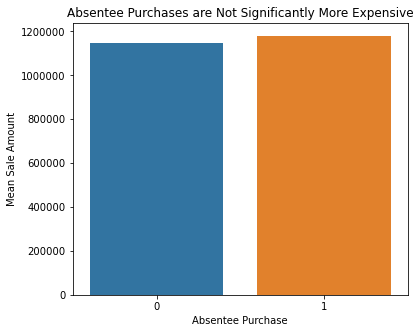

In [24]:
fig, ax = plt.subplots(figsize = (6,5))

sns.barplot(x = 'Absentee', y = 'Mean Sale Amount', data = absentee_mean)
plt.ticklabel_format(style = 'plain', axis = 'y')
ax.set_title('Absentee Purchases are Not Significantly More Expensive')
ax.set_xlabel('Absentee Purchase')
ax.set_ylabel('Mean Sale Amount')

plt.show()

### Cash Purchases

In [25]:
residences.groupby('CASH PURCHASE INDICATOR', as_index = False)['SALE AMOUNT'].mean()

,CASH PURCHASE INDICATOR,SALE AMOUNT
0,0,1148342.60
1,1,1182264.85


In [26]:
residences.groupby('CASH PURCHASE INDICATOR')['absentee'].value_counts()

CASH PURCHASE INDICATOR  absentee
0                        0           44619
                         1           10567
1                        1           12690
                         0           10719
Name: absentee, dtype: int64

### Inter Family Purchases

In [27]:
residences['INTERFAMILY RELATED INDICATOR'].value_counts()

0    74283
1     4312
Name: INTERFAMILY RELATED INDICATOR, dtype: int64

In [28]:
inter_family_mean = residences.groupby('INTERFAMILY RELATED INDICATOR', as_index = False)['SALE AMOUNT'].mean()
inter_family_mean.columns = ['Inter-Family', 'Mean Sale Amount']
inter_family_mean

,Inter-Family,Mean Sale Amount
0,0,1189586.97
1,1,621981.25


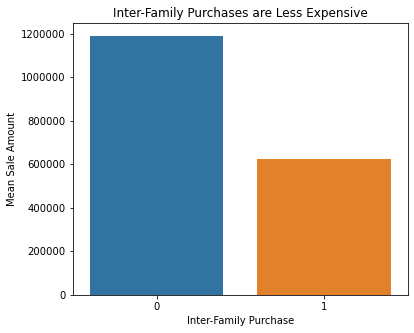

In [29]:
fig, ax = plt.subplots(figsize = (6,5))

sns.barplot(x = 'Inter-Family', y = 'Mean Sale Amount', data = inter_family_mean)
plt.ticklabel_format(style = 'plain', axis = 'y')
ax.set_title('Inter-Family Purchases are Less Expensive')
ax.set_xlabel('Inter-Family Purchase')
ax.set_ylabel('Mean Sale Amount')

plt.show()

In [30]:
from scipy.stats.stats import pearsonr
pearsonr(residences['INTERFAMILY RELATED INDICATOR'], residences['absentee'])

(-0.001953855569146743, 0.5838626764754888)

### Investor Purchases

In [31]:
residences['INVESTOR PURCHASE INDICATOR'].value_counts()

0    77756
1      839
Name: INVESTOR PURCHASE INDICATOR, dtype: int64

In [32]:
residences.groupby('INVESTOR PURCHASE INDICATOR')['SALE AMOUNT'].mean()

INVESTOR PURCHASE INDICATOR
0   1164754.93
1    573763.74
Name: SALE AMOUNT, dtype: float64

In [33]:
# Investor purchases are not significantly correlated with outcome variable absentee
pearsonr(residences['INVESTOR PURCHASE INDICATOR'], residences['absentee'])

(0.1531795566464946, 0.0)

### Absentees over time

In [34]:
yearly_absentees = residences.groupby('sale_year', as_index = False)['absentee'].sum().sort_values(by = 'sale_year')
yearly_total = residences.groupby('sale_year', as_index = False)['SALE AMOUNT'].count().sort_values(by = 'sale_year')
yearly_absentees['total'] = yearly_total['SALE AMOUNT']
yearly_absentees['percent_absentee'] = yearly_absentees['absentee'] / yearly_absentees['total']
yearly_absentees

,sale_year,absentee,total,percent_absentee
0,2009,1702,6601,0.26
1,2010,1997,7120,0.28
2,2011,2093,6638,0.32
3,2012,2617,8362,0.31
4,2013,2447,7845,0.31
5,2014,2412,7431,0.32
6,2015,2274,7266,0.31
7,2016,2150,7372,0.29
8,2017,1841,6673,0.28
9,2018,1846,6757,0.27


<AxesSubplot:xlabel='sale_year', ylabel='absentee'>

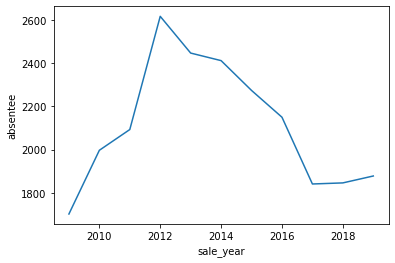

In [35]:
sns.lineplot(data = yearly_absentees, x = 'sale_year', y = 'absentee')

Text(0, 0.5, 'Percent')

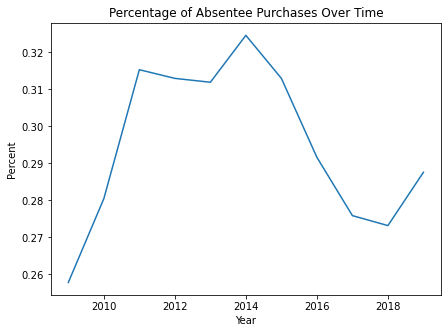

In [36]:
fig, ax = plt.subplots(figsize = (7,5))

sns.lineplot(data = yearly_absentees, x = 'sale_year', y = 'percent_absentee')

plt.ticklabel_format(style = 'plain', axis = 'y')
ax.set_title('Percentage of Absentee Purchases Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Percent')

In [37]:
yearly_med_absentee = residences[residences['absentee'] == 1].groupby('sale_year', as_index = False)['SALE AMOUNT'].median()
yearly_med_absentee

,sale_year,SALE AMOUNT
0,2009,549000.00
1,2010,546480.00
2,2011,550000.00
3,2012,641500.00
4,2013,816000.00
5,2014,978000.00
6,2015,1100000.00
7,2016,1150000.00
8,2017,1180000.00
9,2018,1280000.00


In [38]:
yearly_total_med = residences.groupby('sale_year', as_index = False)['SALE AMOUNT'].median()
yearly_total_med

,sale_year,SALE AMOUNT
0,2009,630000.00
1,2010,645000.00
2,2011,633000.00
3,2012,705000.00
4,2013,830000.00
5,2014,960000.00
6,2015,1100000.00
7,2016,1160550.00
8,2017,1205000.00
9,2018,1310000.00


<AxesSubplot:xlabel='sale_year', ylabel='SALE AMOUNT'>

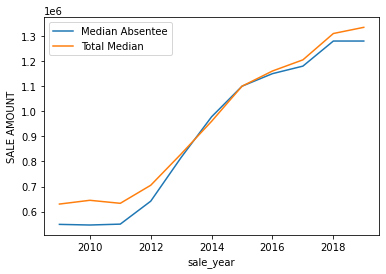

In [39]:
sns.lineplot(data = yearly_med_absentee, x = 'sale_year', y = 'SALE AMOUNT', label = 'Median Absentee')
sns.lineplot(data = yearly_total_med, x = 'sale_year', y = 'SALE AMOUNT', label = 'Total Median')

In [40]:
yearly_mean_absentee = residences[residences['absentee'] == 1].groupby('sale_year', as_index = False)['SALE AMOUNT'].mean()
yearly_mean_non_absentee = residences[residences['absentee'] == 0].groupby('sale_year', as_index = False)['SALE AMOUNT'].mean()

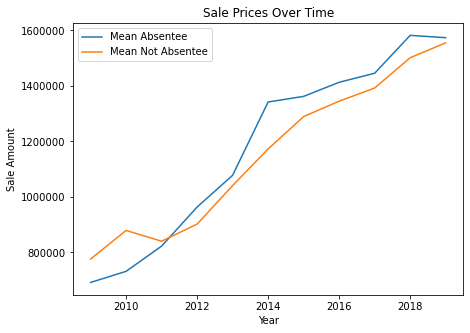

In [41]:
fig, ax = plt.subplots(figsize = (7,5))

sns.lineplot(data = yearly_mean_absentee, x = 'sale_year', y = 'SALE AMOUNT', label = 'Mean Absentee')
sns.lineplot(data = yearly_mean_non_absentee, x = 'sale_year', y = 'SALE AMOUNT', label = 'Mean Not Absentee')

plt.ticklabel_format(style = 'plain', axis = 'y')

ax.set_title('Sale Prices Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Sale Amount')


plt.show()

### Neighborhoods

In [42]:
neighborhood_means = residences.groupby('Analysis Neighborhood', as_index = False)['SALE AMOUNT'].mean().sort_values(by = 'SALE AMOUNT', ascending = False)
neighborhood_means

,Analysis Neighborhood,SALE AMOUNT
30,Seacliff,2790725.66
28,Presidio Heights,2323682.67
15,Marina,1967291.07
25,Pacific Heights,1949179.42
20,Noe Valley,1529907.41
9,Inner Richmond,1520222.83
29,Russian Hill,1446396.18
7,Haight Ashbury,1443018.85
2,Castro/Upper Market,1429827.07
3,Chinatown,1382082.09


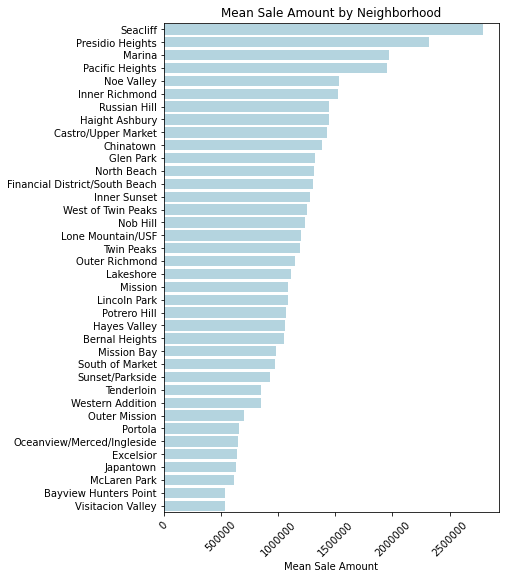

In [43]:
fig, ax = plt.subplots(figsize = (6,9))

sns.barplot(x = 'SALE AMOUNT', y = 'Analysis Neighborhood', data = neighborhood_means, color = 'lightblue')

plt.ticklabel_format(style = 'plain', axis = 'x')
plt.xticks(rotation = 45)

ax.set_title('Mean Sale Amount by Neighborhood')
ax.set_xlabel('Mean Sale Amount')
ax.set_ylabel('')

plt.show()

### Year Built

In [44]:
# Check if year built matches from both datasets
residences[residences['ACTUAL YEAR BUILT - STATIC'] != residences['Year Property Built']][['ACTUAL YEAR BUILT - STATIC', 'Year Property Built']]

,ACTUAL YEAR BUILT - STATIC,Year Property Built
134,NaN,NaN
167,NaN,NaN
189,NaN,1923.00
190,NaN,NaN
195,2017.00,NaN
...,...,...
79176,NaN,2013.00
79184,NaN,NaN
79185,NaN,2009.00
79200,NaN,NaN


In [45]:
# fill null values for year built with column from the other dataset
residences['ACTUAL YEAR BUILT - STATIC'] = residences['ACTUAL YEAR BUILT - STATIC'].fillna(residences['Year Property Built'])

## Regression

First for absentee purchases

In [46]:
variables = ['SALE AMOUNT', 'absentee', 'INTERFAMILY RELATED INDICATOR', 
             'ACTUAL YEAR BUILT - STATIC', 'sale_year', 'Number of Bathrooms', 'Number of Bedrooms', 
             'Number of Stories', 'Property Area', 'Property_type', 'Analysis Neighborhood']

In [47]:
# cast year to string so it is treated as categorical rather than numeric
residences['sale_year'] = residences['sale_year'].astype(str)

In [48]:
variables = pd.get_dummies(residences[variables], drop_first = True)

In [49]:
variables

,SALE AMOUNT,absentee,INTERFAMILY RELATED INDICATOR,ACTUAL YEAR BUILT - STATIC,Number of Bathrooms,Number of Bedrooms,Number of Stories,Property Area,sale_year_2010,sale_year_2011,sale_year_2012,sale_year_2013,sale_year_2014,sale_year_2015,sale_year_2016,sale_year_2017,sale_year_2018,sale_year_2019,Property_type_Duplex,Property_type_Single Family Residential,Analysis Neighborhood_Bernal Heights,Analysis Neighborhood_Castro/Upper Market,Analysis Neighborhood_Chinatown,Analysis Neighborhood_Excelsior,Analysis Neighborhood_Financial District/South Beach,Analysis Neighborhood_Glen Park,Analysis Neighborhood_Haight Ashbury,Analysis Neighborhood_Hayes Valley,Analysis Neighborhood_Inner Richmond,Analysis Neighborhood_Inner Sunset,Analysis Neighborhood_Japantown,Analysis Neighborhood_Lakeshore,Analysis Neighborhood_Lincoln Park,Analysis Neighborhood_Lone Mountain/USF,Analysis Neighborhood_Marina,Analysis Neighborhood_McLaren Park,Analysis Neighborhood_Mission,Analysis Neighborhood_Mission Bay,Analysis Neighborhood_Nob Hill,Analysis Neighborhood_Noe Valley,Analysis Neighborhood_North Beach,Analysis Neighborhood_Oceanview/Merced/Ingleside,Analysis Neighborhood_Outer Mission,Analysis Neighborhood_Outer Richmond,Analysis Neighborhood_Pacific Heights,Analysis Neighborhood_Portola,Analysis Neighborhood_Potrero Hill,Analysis Neighborhood_Presidio Heights,Analysis Neighborhood_Russian Hill,Analysis Neighborhood_Seacliff,Analysis Neighborhood_South of Market,Analysis Neighborhood_Sunset/Parkside,Analysis Neighborhood_Tenderloin,Analysis Neighborhood_Twin Peaks,Analysis Neighborhood_Visitacion Valley,Analysis Neighborhood_West of Twin Peaks,Analysis Neighborhood_Western Addition
0,2010000.00,0,0,2016.00,2.00,3,1.00,1222,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,285000.00,1,0,1907.00,2.00,0,2.00,1900,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1375000.00,0,0,1900.00,2.00,0,2.00,3100,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,698000.00,0,0,1941.00,1.00,0,1.00,890,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1303000.00,0,0,1910.00,1.00,3,1.00,1420,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79236,490000.00,0,0,1907.00,1.00,0,2.00,836,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
79237,1550000.00,0,0,1906.00,1.00,0,1.00,1081,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
79238,565000.00,0,0,1981.00,1.00,1,0.00,550,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
79239,970000.00,0,0,2002.00,0.00,0,3.00,1318,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [50]:
# drop null values, lose about 2000 rows
# base property type is Condominium
# base neighborhood is Bayview Hunters Point
variables.dropna(inplace = True)
variables.shape

(76447, 57)

In [51]:
# take the log of the sale amount
variables['log_sale'] = np.log10(variables['SALE AMOUNT'])

In [52]:
import statsmodels.api as sm

model = sm.OLS(variables['log_sale'], sm.add_constant(variables.drop(['SALE AMOUNT', 'log_sale'], axis = 1)))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               log_sale   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     767.7
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:00:40   Log-Likelihood:                -15827.
No. Observations:               76447   AIC:                         3.177e+04
Df Residuals:                   76390   BIC:                         3.229e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Next for cash purchases

In [53]:
variables = ['SALE AMOUNT', 'CASH PURCHASE INDICATOR', 'INTERFAMILY RELATED INDICATOR', 
             'ACTUAL YEAR BUILT - STATIC', 'sale_year', 'Number of Bathrooms', 'Number of Bedrooms', 
             'Number of Stories', 'Property Area', 'Property_type', 'Analysis Neighborhood']

In [54]:
# cast year to string so it is treated as categorical rather than numeric
residences['sale_year'] = residences['sale_year'].astype(str)

In [55]:
variables = pd.get_dummies(residences[variables], drop_first = True)

In [56]:
# drop null values, lose about 2000 rows
# base property type is Condominium
# base neighborhood is Bayview Hunters Point
variables.dropna(inplace = True)
variables.shape

(76447, 57)

In [57]:
# take the log of the sale amount
variables['log_sale'] = np.log10(variables['SALE AMOUNT'])

In [58]:
import statsmodels.api as sm

model = sm.OLS(variables['log_sale'], sm.add_constant(variables.drop(['SALE AMOUNT', 'log_sale'], axis = 1)))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               log_sale   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     780.2
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:00:40   Log-Likelihood:                -15603.
No. Observations:               76447   AIC:                         3.132e+04
Df Residuals:                   76390   BIC:                         3.185e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

### Interaction

First for absentee

In [59]:
import statsmodels.formula.api as smf

model = smf.ols(formula = 'np.log10(Q("SALE AMOUNT")) ~ absentee + Q("INTERFAMILY RELATED INDICATOR") + Q("ACTUAL YEAR BUILT - STATIC") + Q("Number of Bathrooms") + Q("Number of Bedrooms") + Q("Number of Stories") + Q("Property Area")+ C(Property_type) + C(sale_year) + Q("Analysis Neighborhood") + absentee * Q("Analysis Neighborhood")', data = residences)
results_abs = model.fit()
print(results_abs.summary())

                                OLS Regression Results                                
Dep. Variable:     np.log10(Q("SALE AMOUNT"))   R-squared:                       0.363
Model:                                    OLS   Adj. R-squared:                  0.362
Method:                         Least Squares   F-statistic:                     467.8
Date:                        Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                                12:00:42   Log-Likelihood:                -15653.
No. Observations:                       76429   AIC:                         3.149e+04
Df Residuals:                           76335   BIC:                         3.236e+04
Df Model:                                  93                                         
Covariance Type:                    nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025     

In [60]:
# print(results_abs.summary2().as_html())

For cash purchases

In [61]:
import statsmodels.formula.api as smf

model = smf.ols(formula = 'np.log10(Q("SALE AMOUNT")) ~ Q("CASH PURCHASE INDICATOR") + Q("INTERFAMILY RELATED INDICATOR") + Q("ACTUAL YEAR BUILT - STATIC") + Q("Number of Bathrooms") + Q("Number of Bedrooms") + Q("Number of Stories") + Q("Property Area")+ C(Property_type) + C(sale_year) + Q("Analysis Neighborhood") + Q("CASH PURCHASE INDICATOR") * Q("Analysis Neighborhood")', data = residences)
results_cash = model.fit()
print(results_cash.summary())

                                OLS Regression Results                                
Dep. Variable:     np.log10(Q("SALE AMOUNT"))   R-squared:                       0.368
Model:                                    OLS   Adj. R-squared:                  0.367
Method:                         Least Squares   F-statistic:                     478.2
Date:                        Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                                12:00:43   Log-Likelihood:                -15346.
No. Observations:                       76429   AIC:                         3.088e+04
Df Residuals:                           76335   BIC:                         3.175e+04
Df Model:                                  93                                         
Covariance Type:                    nonrobust                                         
                                                                                                coef    std err          t      P>

In [62]:
# print(results_cash.summary2().as_html())

### Plotting Coefficients with Point and Whiskers Plot
From: https://zhiyzuo.github.io/Python-Plot-Regression-Coefficient/

#### Year

In [63]:
err_series = results_abs.params - results_abs.conf_int()[0]
# err_series

In [64]:
year_coef_df = pd.DataFrame({'coef': results_abs.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       })
year_coef_df

,coef,err,varname
0,0.19,0.01,C(Property_type)[T.Duplex]
1,0.23,0.01,C(Property_type)[T.Single Family Residential]
2,0.03,0.01,C(sale_year)[T.2010]
3,0.03,0.01,C(sale_year)[T.2011]
4,0.06,0.01,C(sale_year)[T.2012]
5,0.14,0.01,C(sale_year)[T.2013]
6,0.20,0.01,C(sale_year)[T.2014]
7,0.24,0.01,C(sale_year)[T.2015]
8,0.26,0.01,C(sale_year)[T.2016]
9,0.25,0.01,C(sale_year)[T.2017]


In [65]:
year_coef_df = year_coef_df.iloc[2:12]

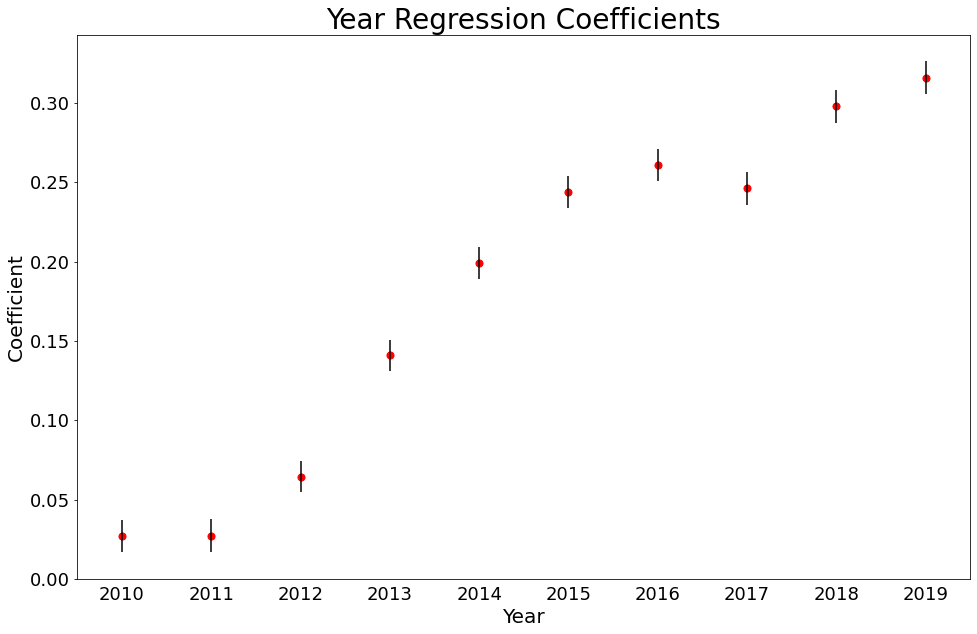

In [66]:
fig, ax = plt.subplots(figsize=(16,10))
year_coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('Coefficient', fontsize = 20)
ax.set_xlabel('Year', fontsize = 20)
ax.set_title('Year Regression Coefficients', fontsize = 28)
ax.scatter(x=np.arange(year_coef_df.shape[0]), 
           marker='o', s=50, 
           y=year_coef_df['coef'], color='red')
ax.xaxis.set_ticks_position('none')

_ = ax.set_xticklabels(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], 
                       rotation=0, fontsize=18)
_ = plt.yticks(fontsize = 18)

#### Interaction of Absentee and Neighborhood

In [67]:
# add the interaction terms
interaction_sums = results_abs.params.loc['absentee'] + results_abs.params.iloc[51:88]
# interaction_sums

In [68]:
# calculate covariances of absentee with each neighborhood interaction
covs = results_abs.cov_params().loc['absentee'].iloc[51:88]
# covs

In [69]:
# calculate the standard error of the added coefficients
summed_se = np.sqrt(results_abs.bse[51:88] ** 2 + results_abs.bse.loc['absentee'] ** 2 + 2*covs)

In [70]:
# calculate the error corresponding with a 95% confidence interval of each coefficient
err_series = 1.96 * (summed_se / np.sqrt(len(interaction_sums)))
# err_series

In [71]:
# get names of neighborhoods
names = pd.DataFrame(residences['Analysis Neighborhood'].unique()).sort_values(by = 0)

# drop 14 bayview because it is the baseline and not labelled. Will exclude for the purposes of this visualization
# drop 15 NaN
names = names.drop(labels = [1, 38], axis = 0)

In [72]:
ne_coef_df = pd.DataFrame({'coef': interaction_sums,
                        'err': err_series.values,
                        'varname': err_series.index.values,
                        'label': names[0].values
                       })

# add back in baseline bayview hunters point
ne_coef_df = ne_coef_df.append(pd.DataFrame({'coef': results_abs.params.loc['absentee'],
                              'err': results_abs.params.loc['absentee'] - results_abs.conf_int().loc['absentee'][0],
                              'varname': 'Bayview Hunters Point',
                              'label': 'Bayview Hunters Point'}, index = ['Bayview']))

# sort values
ne_coef_df = ne_coef_df.sort_values(by = 'coef')

In [73]:
# ne_coef_df.to_csv('absentee_coefs.csv')

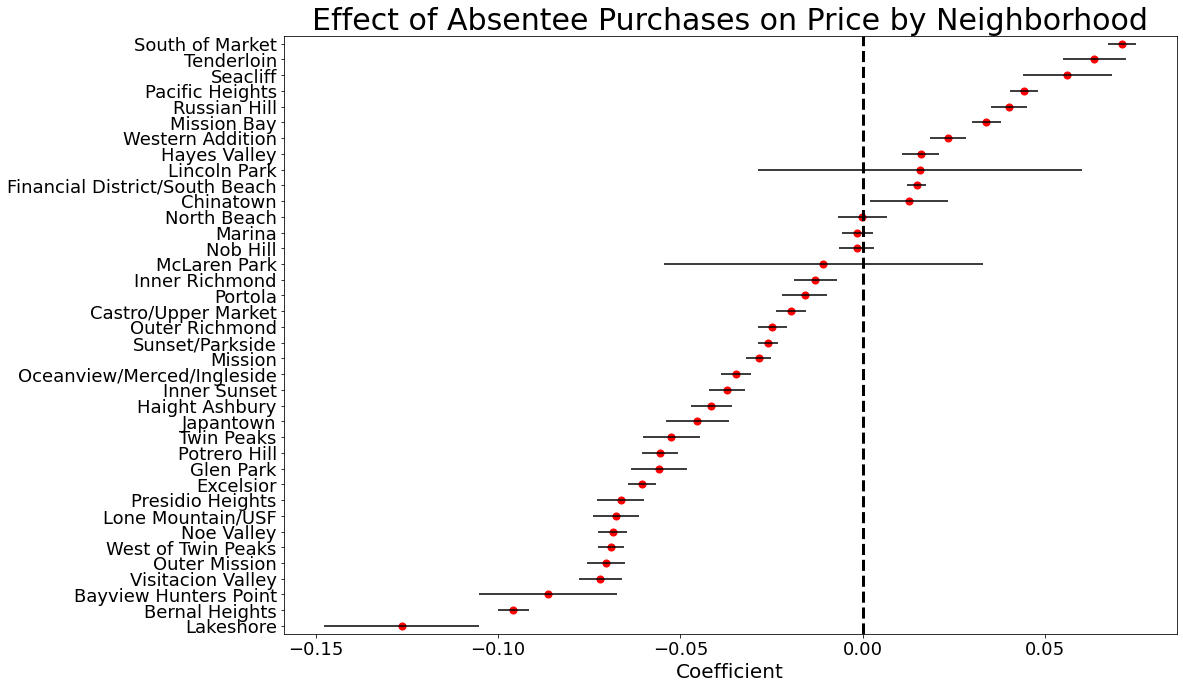

In [74]:
fig, ax = plt.subplots(figsize=(16, 11))
ne_coef_df.plot(x='varname', y='coef', kind='barh', 
             ax=ax, color='none', 
             xerr='err', legend=False)

ax.scatter(y=np.arange(ne_coef_df.shape[0]), 
           marker='o', s=50, 
           x=ne_coef_df['coef'], color='red')

ax.axvline(x = 0, color = 'black', linestyle = '--', linewidth = 3)

ax.set_xlabel('Coefficient', fontsize = 20)
ax.set_ylabel('')
ax.set_title('Effect of Absentee Purchases on Price by Neighborhood', fontsize = 30)

_ = ax.set_yticklabels(ne_coef_df['label'], 
                       rotation=0, fontsize=18)
_ = plt.xticks(fontsize = 18)

#### Interaction of cash purchases and neighborhood

In [75]:
# add the interaction terms
interaction_sums = results_cash.params.loc['Q("CASH PURCHASE INDICATOR")'] + results_cash.params.iloc[51:88]
# interaction_sums

In [76]:
# calculate covariances of cash purchase with each neighborhood interaction

covs = results_cash.cov_params().loc['Q("CASH PURCHASE INDICATOR")'].iloc[51:88]
# covs

In [77]:
# calculate the standard error of the added coefficients
summed_se = np.sqrt(results_cash.bse[51:88] ** 2 + results_cash.bse.loc['Q("CASH PURCHASE INDICATOR")'] ** 2 + 2*covs)

In [78]:
# calculate the error corresponding with a 95% confidence interval of each coefficient
err_series = 1.96 * (summed_se / np.sqrt(len(interaction_sums)))
# err_series

In [79]:
# get names of neighborhoods
names = pd.DataFrame(residences['Analysis Neighborhood'].unique()).sort_values(by = 0)

# drop 14 bayview because it is the baseline and not labelled. Will exclude for the purposes of this visualization
# drop 15 NaN
names = names.drop(labels = [1, 38], axis = 0)

In [80]:
ne_coef_df = pd.DataFrame({'coef': interaction_sums,
                        'err': err_series.values,
                        'varname': err_series.index.values,
                        'label': names[0].values
                       })

# add back in baseline bayview hunters point
ne_coef_df = ne_coef_df.append(pd.DataFrame({'coef': results_cash.params.loc['Q("CASH PURCHASE INDICATOR")'],
                              'err': results_cash.params.loc['Q("CASH PURCHASE INDICATOR")'] - results_cash.conf_int().loc['Q("CASH PURCHASE INDICATOR")'][0],
                              'varname': 'Bayview Hunters Point',
                              'label': 'Bayview Hunters Point'}, index = ['Bayview']))

# sort values
ne_coef_df = ne_coef_df.sort_values(by = 'coef')

In [81]:
# ne_coef_df.to_csv('cash_coefs.csv')

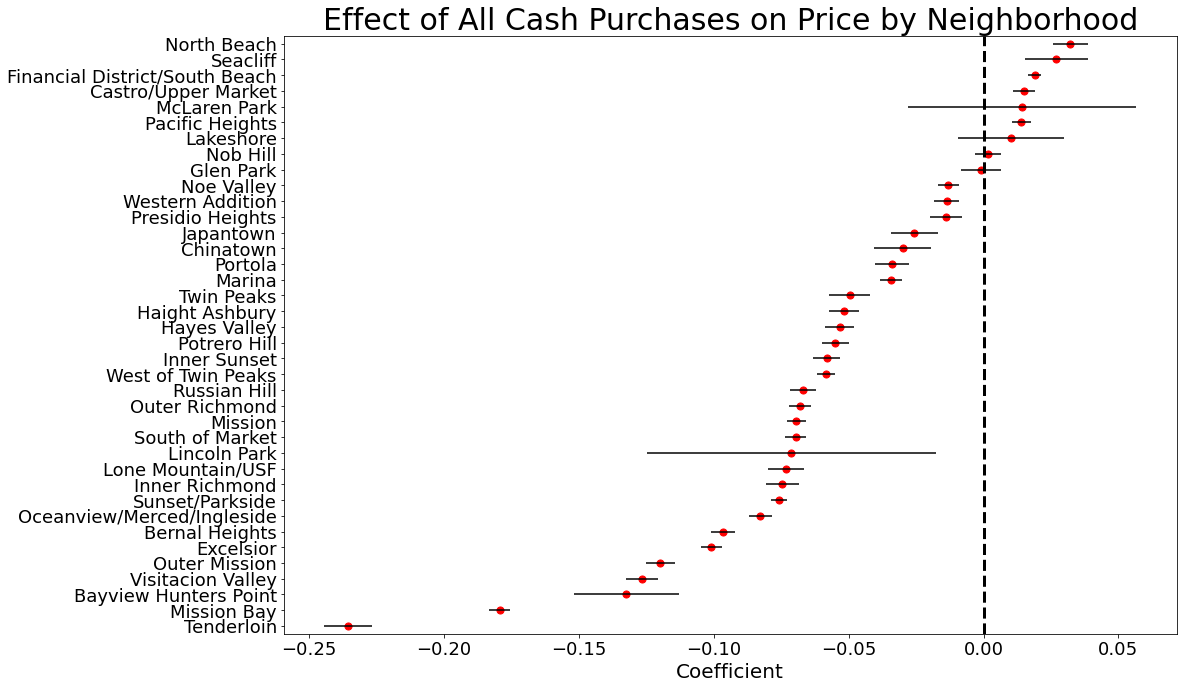

In [82]:
fig, ax = plt.subplots(figsize=(16, 11))
ne_coef_df.plot(x='varname', y='coef', kind='barh', 
             ax=ax, color='none', 
             xerr='err', legend=False)

ax.scatter(y=np.arange(ne_coef_df.shape[0]), 
           marker='o', s=50, 
           x=ne_coef_df['coef'], color='red')

ax.axvline(x = 0, color = 'black', linestyle = '--', linewidth = 3)

ax.set_xlabel('Coefficient', fontsize = 20)
ax.set_ylabel('')
ax.set_title('Effect of All Cash Purchases on Price by Neighborhood', fontsize = 30)

_ = ax.set_yticklabels(ne_coef_df['label'], 
                       rotation=0, fontsize=18)
_ = plt.xticks(fontsize = 18)

### Propensity score matching

In [83]:
indices_train = np.random.choice(residences.index, size = int(len(residences.index) / 2), replace = False)

In [84]:
train = residences.loc[indices_train]

In [85]:
test = residences[~residences.index.isin(indices_train)]

In [86]:
train.shape

(39297, 162)

In [87]:
test.shape

(39298, 162)

In [88]:
variables_psm = ['absentee', 'INTERFAMILY RELATED INDICATOR', 
             'ACTUAL YEAR BUILT - STATIC', 'sale_year', 'Number of Bathrooms', 'Number of Bedrooms', 
             'Number of Stories', 'Property Area', 'Property_type', 'Analysis Neighborhood']

In [89]:
# cast year to string so it is treated as categorical rather than numeric
train['sale_year'] = train['sale_year'].astype(str)

In [90]:
variables_psm = pd.get_dummies(train[variables_psm], drop_first = True)

In [91]:
variables_psm.dropna(inplace = True)
variables_psm.shape

(38194, 56)

In [92]:
X = variables_psm.drop('absentee', axis = 1)
y = variables_psm['absentee']

In [93]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(solver = 'liblinear')
logit.fit(X, y)

LogisticRegression(solver='liblinear')

In [94]:
variables_psm = ['absentee', 'SALE AMOUNT', 'INTERFAMILY RELATED INDICATOR', 
             'ACTUAL YEAR BUILT - STATIC', 'sale_year', 'Number of Bathrooms', 'Number of Bedrooms', 
             'Number of Stories', 'Property Area', 'Property_type', 'Analysis Neighborhood']

In [95]:
test_X = test[variables_psm]

In [96]:
test_X = pd.get_dummies(test_X, drop_first = True)

In [97]:
test_X.dropna(inplace = True)

In [98]:
probabilities = logit.predict_proba(test_X.drop(['absentee', 'SALE AMOUNT'], axis = 1))

In [99]:
propensity_scores = [el[1] for el in probabilities]

In [100]:
propensity_scores

[0.26859958228923314,
 0.6047848134100924,
 0.24573671359811697,
 0.20235827957497976,
 0.2850194624608347,
 0.1857636931349324,
 0.19672233357482077,
 0.40210105990667266,
 0.27202470608747154,
 0.33856111923006166,
 0.3673460768170514,
 0.3062262906713604,
 0.3620248995100247,
 0.1314718647422338,
 0.1314718647422338,
 0.27518186180111076,
 0.2442530823614204,
 0.49848931585274564,
 0.29615650301605545,
 0.25319029744216826,
 0.2438139262911211,
 0.5275091684461669,
 0.35789422256028197,
 0.2885346481458078,
 0.4085627571744134,
 0.18612609541386177,
 0.22212781300827156,
 0.35354784602814643,
 0.35354784602814643,
 0.21153056229484365,
 0.22048818798941233,
 0.22048818798941233,
 0.22619098279178232,
 0.2518283652490708,
 0.18668480254987813,
 0.28488978334930987,
 0.2452480378050201,
 0.2449636334770897,
 0.28204762263871164,
 0.2569234189298163,
 0.30608232080477416,
 0.24953223590924933,
 0.32086290282764557,
 0.34954379953775294,
 0.2320184876686445,
 0.2282128134034875,
 0.2504

In [101]:
test_X['propensity_score'] = propensity_scores

In [102]:
test_X

,absentee,SALE AMOUNT,INTERFAMILY RELATED INDICATOR,ACTUAL YEAR BUILT - STATIC,Number of Bathrooms,Number of Bedrooms,Number of Stories,Property Area,sale_year_2010,sale_year_2011,sale_year_2012,sale_year_2013,sale_year_2014,sale_year_2015,sale_year_2016,sale_year_2017,sale_year_2018,sale_year_2019,Property_type_Duplex,Property_type_Single Family Residential,Analysis Neighborhood_Bernal Heights,Analysis Neighborhood_Castro/Upper Market,Analysis Neighborhood_Chinatown,Analysis Neighborhood_Excelsior,Analysis Neighborhood_Financial District/South Beach,Analysis Neighborhood_Glen Park,Analysis Neighborhood_Haight Ashbury,Analysis Neighborhood_Hayes Valley,Analysis Neighborhood_Inner Richmond,Analysis Neighborhood_Inner Sunset,Analysis Neighborhood_Japantown,Analysis Neighborhood_Lakeshore,Analysis Neighborhood_Lincoln Park,Analysis Neighborhood_Lone Mountain/USF,Analysis Neighborhood_Marina,Analysis Neighborhood_McLaren Park,Analysis Neighborhood_Mission,Analysis Neighborhood_Mission Bay,Analysis Neighborhood_Nob Hill,Analysis Neighborhood_Noe Valley,Analysis Neighborhood_North Beach,Analysis Neighborhood_Oceanview/Merced/Ingleside,Analysis Neighborhood_Outer Mission,Analysis Neighborhood_Outer Richmond,Analysis Neighborhood_Pacific Heights,Analysis Neighborhood_Portola,Analysis Neighborhood_Potrero Hill,Analysis Neighborhood_Presidio Heights,Analysis Neighborhood_Russian Hill,Analysis Neighborhood_Seacliff,Analysis Neighborhood_South of Market,Analysis Neighborhood_Sunset/Parkside,Analysis Neighborhood_Tenderloin,Analysis Neighborhood_Twin Peaks,Analysis Neighborhood_Visitacion Valley,Analysis Neighborhood_West of Twin Peaks,Analysis Neighborhood_Western Addition,propensity_score
0,0,2010000.00,0,2016.00,2.00,3,1.00,1222,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.27
1,1,285000.00,0,1907.00,2.00,0,2.00,1900,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.60
3,0,698000.00,0,1941.00,1.00,0,1.00,890,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.25
6,0,3150000.00,0,1905.00,2.00,4,3.00,2287,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.20
8,0,1313000.00,0,2012.00,2.00,2,0.00,1492,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79230,0,215000.00,0,2004.00,2.00,2,1.00,1553,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.25
79231,0,590000.00,0,2003.00,0.00,0,0.00,967,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.41
79232,0,1675000.00,0,1921.00,2.00,3,2.00,1690,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.26
79235,0,466500.00,0,2001.00,0.00,0,0.00,711,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.23


In [103]:
test_X['log_sale'] = np.log10(test_X['SALE AMOUNT'])

In [104]:
model = sm.OLS(test_X['log_sale'], sm.add_constant(test_X.drop(['SALE AMOUNT', 'log_sale'], axis = 1)))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               log_sale   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     378.2
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:00:45   Log-Likelihood:                -8194.7
No. Observations:               38253   AIC:                         1.651e+04
Df Residuals:                   38195   BIC:                         1.700e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [105]:
# write final dataset to CSV
# residences.to_csv('residences_final.csv')